<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_3Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [ ]:
!pip install datasets transformers[sentencepiece] kaggle

# Kaggle API Key 설정
import os
os.environ['KAGGLE_USERNAME'] = "sypark20" # Kaggle username 입력
os.environ['KAGGLE_KEY'] = "cc7952d167c6538e42c3f9d9a75d6f18" # Kaggle API key 입력

# 데이터셋 다운로드
!kaggle datasets download -d devicharith/language-translation-englishfrench

# 압축 해제
!unzip language-translation-englishfrench.zip

Dataset URL: https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench
License(s): CC0-1.0
  0% 0.00/3.51M [00:00<?, ?B/s]
100% 3.51M/3.51M [00:00<00:00, 75.9MB/s]
Archive:  language-translation-englishfrench.zip
  inflating: eng_-french.csv         


## [MY CODE] BERT

In [ ]:
import torch
import pandas as pd
import kagglehub
from datasets import load_dataset
from torch.utils.data import DataLoader

# Download latest version
path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")

# 데이터 불러오기
df = pd.read_csv(path + '/eng_-french.csv')  # 파일 경로 수정

# 필요한 열만 선택
df = df[['English words/sentences', 'French words/sentences']]

# 열 이름 변경
df.columns = ['en', 'fr']

# 데이터셋 분리
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터 줄이기
train_df = train_df.sample(frac=0.15, random_state=42)  # 15%만 사용
val_df = val_df.sample(frac=0.15, random_state=42)  # 15%만 사용

# Hugging Face Datasets으로 변환
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# 토크나이저 불러오기
from transformers import AutoTokenizer
model_checkpoint = "bert-base-multilingual-cased"  # For BERT
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', model_checkpoint)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [ ]:

def collate_fn(batch):
  max_len = 512
  texts, targets = [], []
  for row in batch:
    targets.append(row['fr'])
    texts.append(row['en'])

  tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  targets = torch.LongTensor([tokenizer(targets, padding=True, truncation=True, max_length=max_len).input_ids[0] for target in targets])


  return texts, targets


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn
)

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [ ]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 1)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x)

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [ ]:
from torch.optim import Adam
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCELoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = preds[:, 0]  # [CLS] 토큰 예측 가져오기
    preds = F.sigmoid(preds) # 시그모이드 함수 적용

    # Ensure labels are floats and between 0 and 1
    labels = labels[:, 0].float()
    # Clamp labels to be between 0 and 1 to avoid assertion errors
    labels = torch.clamp(labels, 0, 1)

    loss = loss_fn(preds.squeeze(1), labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


KeyboardInterrupt: 

In [ ]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = (preds > 0).long() # 0 또는 1 값을 가지는 텐서로 변환
        labels = labels.view(-1) # labels를 1차원으로 변환

        min_len = min(preds.shape[0], labels.shape[0])  # 최소 길이 계산
        cnt += labels.shape[0]
        acc += (labels[:min_len] == preds[:min_len, 0]).sum().item()  # Compare elements up to min_len

    return acc / cnt


with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Loss가 잘 떨어지고, 이전에 우리가 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있습니다.

## [MY CODE[ Pre-trained 모델 선정
 - Helsinki-NLP/opus-mt-en-fr: 번역 작업에 적합 (seq2seq 모델)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import kagglehub
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# 번역을 위한 모델 클래스 정의
class TranslationModel(torch.nn.Module):
    def __init__(self, model_checkpoint):
        super().__init__()
        # Seq2Seq 모델을 로드 (번역용)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None):
        # 모델 출력을 반환 (디코더 입력도 포함)
        return self.model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)

# 데이터 전처리 함수
def preprocess_data(df, tokenizer, max_length=128):
    def encode(row):
        # 영어 텍스트를 토크나이즈하여 번역할 준비
        encoded = tokenizer(row['en'], max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
        target_encoded = tokenizer(row['fr'], max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'decoder_input_ids': target_encoded['input_ids'].squeeze(0),  # 프랑스어 문장을 디코더 입력으로
            'target_text': row['fr']  # 실제 프랑스어 문장을 반환
        }
    return [encode(row) for _, row in df.iterrows()]

In [ ]:
# 데이터셋 로드 및 전처리
path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")

# 데이터 불러오기
df = pd.read_csv(path + '/eng_-french.csv')  # 파일 경로 수정

# 필요한 열만 선택
df = df[['English words/sentences', 'French words/sentences']]

# 열 이름 변경
df.columns = ['en', 'fr']

# 데이터셋 분리
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 번역 모델에 적합한 모델 및 토크나이저 선택
model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"  # 영어에서 프랑스어로 번역하는 모델
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = preprocess_data(train_df, tokenizer)
val_data = preprocess_data(val_df, tokenizer)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [ ]:
# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TranslationModel(model_checkpoint).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# 학습률을 동적으로 조정하는 LearningRateScheduler 사용
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [ ]:
# 번역 함수
def translate(model, dataloader):
    model.eval()
    translations = []

    for data in dataloader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        decoder_input_ids = data['decoder_input_ids'].to(device)  # 디코더 입력을 받아옵니다

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, decoder_input_ids=decoder_input_ids)

        # 모델의 출력을 텍스트로 변환
        translated_ids = outputs.logits.argmax(dim=-1)  # 가장 확률이 높은 단어의 인덱스 선택
        translated_texts = tokenizer.batch_decode(translated_ids, skip_special_tokens=True)

        translations.extend(translated_texts)

    return translations

In [ ]:
# 학습
n_epochs = 3

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.

    for data in train_loader:
        optimizer.zero_grad()

        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        decoder_input_ids = data['decoder_input_ids'].to(device)  # 디코더 입력 추가

        # 모델에 의한 출력
        outputs = model(input_ids, attention_mask, decoder_input_ids=decoder_input_ids)

        # 출력과 실제 프랑스어 문장에 대한 손실 계산
        labels = tokenizer(data['target_text'], return_tensors="pt", padding=True, truncation=True, max_length=128).input_ids.to(device)
        loss = model.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} | Train Loss: {total_loss:.4f}")

    # 번역 예시
    with torch.no_grad():
        translations = translate(model, val_loader)
        print(f"Sample translations: {translations[:5]}")  # 샘플 번역 5개 출력

ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

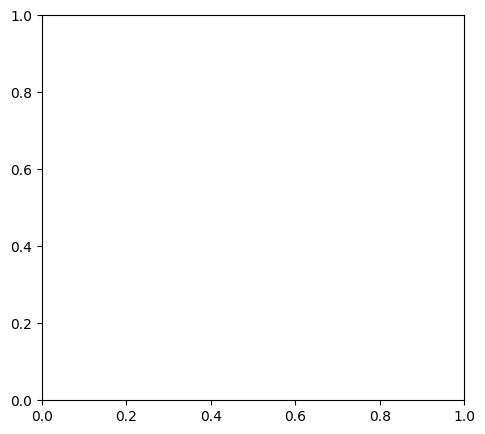

In [ ]:
import matplotlib.pyplot as plt

# 에포크 수 정의
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 5))

# 1. 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, label='Train Loss', marker='o')  # 'train_losses' -> 'train_accs'로 수정
plt.plot(epochs, test_accs, label='Test Loss', marker='o')    # 'test_losses' -> 'test_accs'로 수정
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# 2. 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')  # 'train_accuracies' -> 'train_accs'로 수정
plt.plot(epochs, test_accs, label='Test Accuracy', marker='o')    # 'test_accuracies' -> 'test_accs'로 수정
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## [MY CODE] 번역 테스트

In [ ]:
def translate(model, tokenizer, text, max_length=128):
    """
    번역을 수행하는 함수.
    Args:
        model: 번역에 사용되는 모델.
        tokenizer: 텍스트를 토큰화하는 데 사용되는 토크나이저.
        text (str): 번역할 텍스트.
        max_length (int): 생성할 텍스트의 최대 길이. 기본값은 128.

    Returns:
        str: 번역된 텍스트.
    """
    # 입력 텍스트를 토큰화하고 텐서로 변환
    input_ids = tokenizer.encode(text, return_tensors="pt").to('cuda')

    # 모델을 사용해 번역 생성
    translated_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,  # Beam search로 더 나은 결과를 얻기 위한 설정
        early_stopping=True  # 조기 종료 활성화
    )

    # 번역된 텍스트 디코딩
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)

    return translated_text

# 번역 테스트 예제
text = "This is a test sentence."
translated_text = translate(model, tokenizer, text)  # model과 tokenizer 사용
print(f"Original: {text}")
print(f"Translated: {translated_text}")
